In [3296]:
import pandas as pd
import numpy as np
#from scipy import stats as st
#import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import sklearn
#import math
import shap
# функция для разделения данных
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV 
# функция кодирования категориальных признаков
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
# функция для стандартизация количественных признаков
from sklearn.preprocessing import StandardScaler#, PolynomialFeatures
# функция линейной регрессии
#from sklearn.linear_model import LinearRegression
# функции для метрик
#from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import recall_score
#from sklearn.metrics import precision_score, f1_score
from sklearn.metrics import roc_auc_score
# функции для логистической регрессии
from sklearn.linear_model import LogisticRegression
#from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
# функция метода опорных векторов
from sklearn.svm import SVC
# функция разделения между классами
from mlxtend.plotting import plot_decision_regions

from sklearn.neighbors import KNeighborsClassifier 

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

from sklearn.tree import DecisionTreeClassifier

from sklearn.impute import SimpleImputer

#from scipy.stats.stats import pearsonr
#from sklearn.inspection import permutation_importance

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

TEST_SIZE = 0.25
RANDOM_STATE = 77

### Функции

### Загрузка данных

#### Данные о поведении покупателей

In [3297]:
market_file= pd.read_csv('datasets/market_file.csv', sep=',', low_memory=False)
market_file_copy = market_file.copy()
market_file_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [3298]:
market_file_copy.sample(5)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
319,215667,Снизилась,премиум,да,3.0,4,467,0.95,Косметика и аксесуары,2,6,7,3
293,215641,Снизилась,премиум,да,4.1,4,666,0.99,Товары для детей,2,3,7,6
462,215810,Снизилась,стандарт,нет,4.4,4,417,0.23,Товары для детей,3,0,6,10
817,216165,Прежний уровень,стандарт,нет,5.4,4,142,0.15,Домашний текстиль,5,3,6,10
264,215612,Снизилась,премиум,нет,4.4,3,255,0.94,Домашний текстиль,3,5,7,7


In [3299]:
market_file_copy.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


In [3300]:
# рассмотрим категориальные данные
market_file_copy.describe(include = 'object')

,Покупательская активность,Тип сервиса,Разрешить сообщать,Популярная_категория
count,1300,1300,1300,1300
unique,2,3,2,6
top,Прежний уровень,стандарт,да,Товары для детей
freq,802,914,962,330


Предварительный вывод по данным:
1. Покупательская активность - целевой бинарный категориальный показатель для модели.
2. Признаки из группы "Коммуникация с клиентом": Тип сервиса (категория), Разрешить сообщать (категория, бинарная), Маркет_актив_6_мес (среднемес кол-во рассылок, звонков, рекламы за последние 6 мес.), Маркет_актив_тек_мес (кол-во рассылок, звонков, рекламы за последний месяц), Длительность (кол-во дней с даты регистрации на сайте)
3. Признаки из группы "Продуктовое поведение": Популярная_категория (со всех заказов за 6 мес.), Средний_просмотр_категорий_за_визит (за последний месяц сколько категорий в среднем просмотрел покупатель за 1 визит на сайт), Неоплаченные_продукты_штук_квартал (всего неоплаченных товаров в корзине за последние 3 мес.)
4. Признаки из группы "Поведение на сайте": Страниц_за_визит (за последние 3 мес.) и Ошибка_сервиса (итого за все время)

#### Выручка с каждого покупателя

In [3301]:
market_money= pd.read_csv('datasets/market_money.csv', sep=',', low_memory=False)
market_money_copy = market_money.copy()
market_money_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [3302]:
market_money_copy.sample(5)

,id,Период,Выручка
2289,216111,препредыдущий_месяц,4809.0
2384,216142,препредыдущий_месяц,4974.0
2878,216307,текущий_месяц,6335.8
2801,216281,текущий_месяц,6796.6
1969,216004,предыдущий_месяц,6029.0


In [3303]:
market_money_copy.describe()

,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


Предварительные выводы по данным:
1. выручка за три периода (указаны списком в отдельном столбце): за текщий ,предыдущий, предпредыдущий месяц.
2. есть выброс в выручке. Лучше убрать, иначе помешает при масштабировании

#### Данные о времени, проведенном на сайте

In [3304]:
market_time= pd.read_csv('datasets/market_time.csv', sep=',', low_memory=False)
market_time_copy = market_time.copy()
market_time_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [3305]:
market_time_copy.sample(5)

,id,Период,минут
2519,216607,предыдцщий_месяц,11
1712,216204,предыдцщий_месяц,20
641,215668,текущий_месяц,9
2051,216373,текущий_месяц,7
1072,215884,предыдцщий_месяц,13


In [3306]:
market_time_copy.describe()

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


Предварительные выводы по данным:
1. количество минут, проведенных пользователем на сайте за период

#### Данные по среднемесячной прибыли от каждого покупателя за последние 3 месяца

In [3307]:
money= pd.read_csv('datasets/money.csv', sep=';', low_memory=False)
money_copy = money.copy()
money_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


In [3308]:
money_copy.sample(5)

,id,Прибыль
36,215384,"4,78"
958,216306,"4,81"
444,215792,"3,24"
548,215896,"3,73"
777,216125,"2,48"


Проверим соответствие id пользователей в этом датасете с дсатасетом с данными по пользовательскому поведению

In [3309]:
market_file_copy.index[~market_file_copy.index.isin(money_copy.index)]

Index([], dtype='int64')

все id совпадают

Предварительные выводы по данным:
1. Данные о среднемесячной прибыли за последние 3 месяца с каждого покупателя. Id полностью соответствуют id из первого датасета.

### Предобработка данных

#### Данные о поведении покупателей

##### Поиск дубликатов

In [3310]:
market_file_copy.duplicated().sum()

0

In [3311]:
print(f'Размер дс до удаления дублей: {market_file_copy.shape}')
market_file_copy['Тип сервиса'] = market_file_copy['Тип сервиса'].replace('стандартт', 'стандарт')
print(f'Размер дс после удаления дублей: {market_file_copy.shape}')

Размер дс до удаления дублей: (1300, 13)
Размер дс после удаления дублей: (1300, 13)


исключены скрытые дубликаты в столбце "Тип сервиса"

In [3312]:
market_file_copy['Маркет_актив_6_мес'] = market_file_copy['Маркет_актив_6_мес'].astype('int64')

#### Данные о выручка с каждого покупателя

In [3313]:
market_money_copy.duplicated().sum()

0

In [3314]:
# удалим выброс в 106к
print(f'Размер дс до удаления выброса: {market_money_copy.shape}')
market_money_copy.loc[market_money_copy['Выручка'] > 20000]['Выручка'] = market_money_copy['Выручка'].median()
#market_money_copy['Выручка'] = market_money_copy['Выручка'].replace(106862.2, market_money_copy['Выручка'].median())
print(f'Размер дс после удаления выброса: {market_money_copy.shape}')

Размер дс до удаления выброса: (3900, 3)
Размер дс после удаления выброса: (3900, 3)


C:\Users\TIMUR\AppData\Local\Temp\ipykernel_18500\1089790544.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_money_copy.loc[market_money_copy['Выручка'] > 20000]['Выручка'] = market_money_copy['Выручка'].median()


In [3315]:
market_money_copy['Период'].value_counts()

Период
препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: count, dtype: int64

#### Данные о времени, проведенном на сайте

In [3316]:
market_time_copy.duplicated().sum()

0

In [3317]:
print(market_time_copy['Период'].value_counts())
print(f'Размер дс до корректировки названия: {market_time_copy.shape}')
market_time_copy['Период'] = market_time_copy['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')
print(f'Размер дс после корректировки названия: {market_time_copy.shape}')
print(market_time_copy['Период'].value_counts())

Период
текущий_месяц       1300
предыдцщий_месяц    1300
Name: count, dtype: int64
Размер дс до корректировки названия: (2600, 3)
Размер дс после корректировки названия: (2600, 3)
Период
текущий_месяц       1300
предыдущий_месяц    1300
Name: count, dtype: int64


#### Данные по среднемесячной прибыли от каждого покупателя за последние 3 месяца

In [3318]:
money_copy.duplicated().sum()

0

преобразуем тип данных из строк в число

In [3319]:
money_copy['Прибыль'] = money_copy['Прибыль'].str.replace(',', '.').astype(float)

### Исследовательский анализ данных

#### Данные о поведении покупателей (количественные значения)

оставим в датасете только данные по пользователям активным в последние 3 месяца.

отберем id пользователей, у которых не было активности в каком то из месяцев за последние 3 месяца. Для этого как меру активности возьмем выручку.

In [3320]:
id_three_months = market_money_copy[market_money_copy['Выручка'] == 0]['id'].drop_duplicates()

сделаем id пользователей индексом таблицы про потребителькое поведение

In [3321]:
market_file_copy = market_file_copy.set_index('id') 

удалим строки с неактивными пользователями.

In [3322]:
print(f'Размер таблицы до изменений: {market_file_copy.shape}')
market_file_copy = market_file_copy[~market_file_copy.index.isin(id_three_months)]
print(f'Размер таблицы после изменений: {market_file_copy.shape}')

Размер таблицы до изменений: (1300, 12)
Размер таблицы после изменений: (1297, 12)


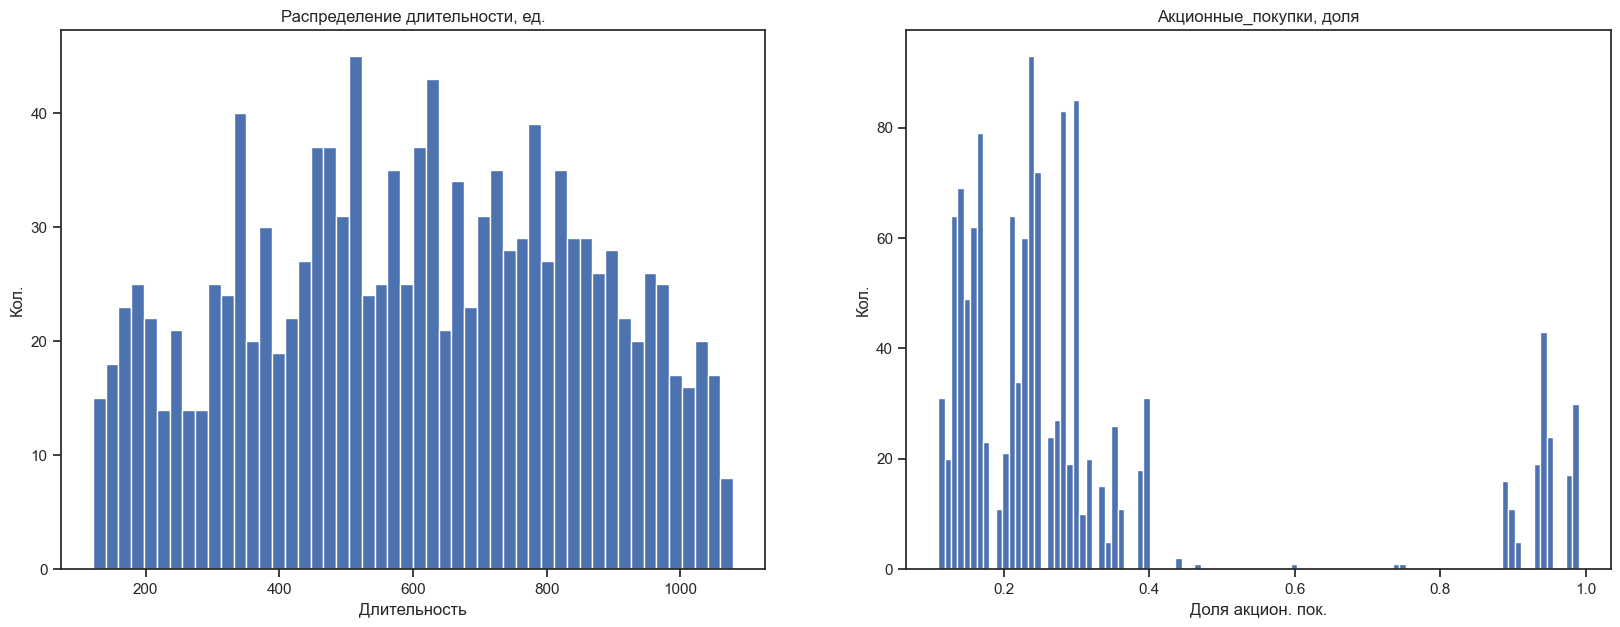

In [3323]:
# визуализируем числовые данные
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize = (20,7))

y1 = market_file_copy['Длительность']
y2 = market_file_copy['Акционные_покупки']

ax1.hist([y1], bins = 50)
ax1.set_xlabel('Длительность')
ax1.set_ylabel('Кол.')
ax1.set_title('Распределение длительности, ед.')

ax2.hist([y2], bins = 100)
ax2.set_xlabel('Доля акцион. пок.')
ax2.set_ylabel('Кол.')
ax2.set_title('Акционные_покупки, доля')

plt.show()

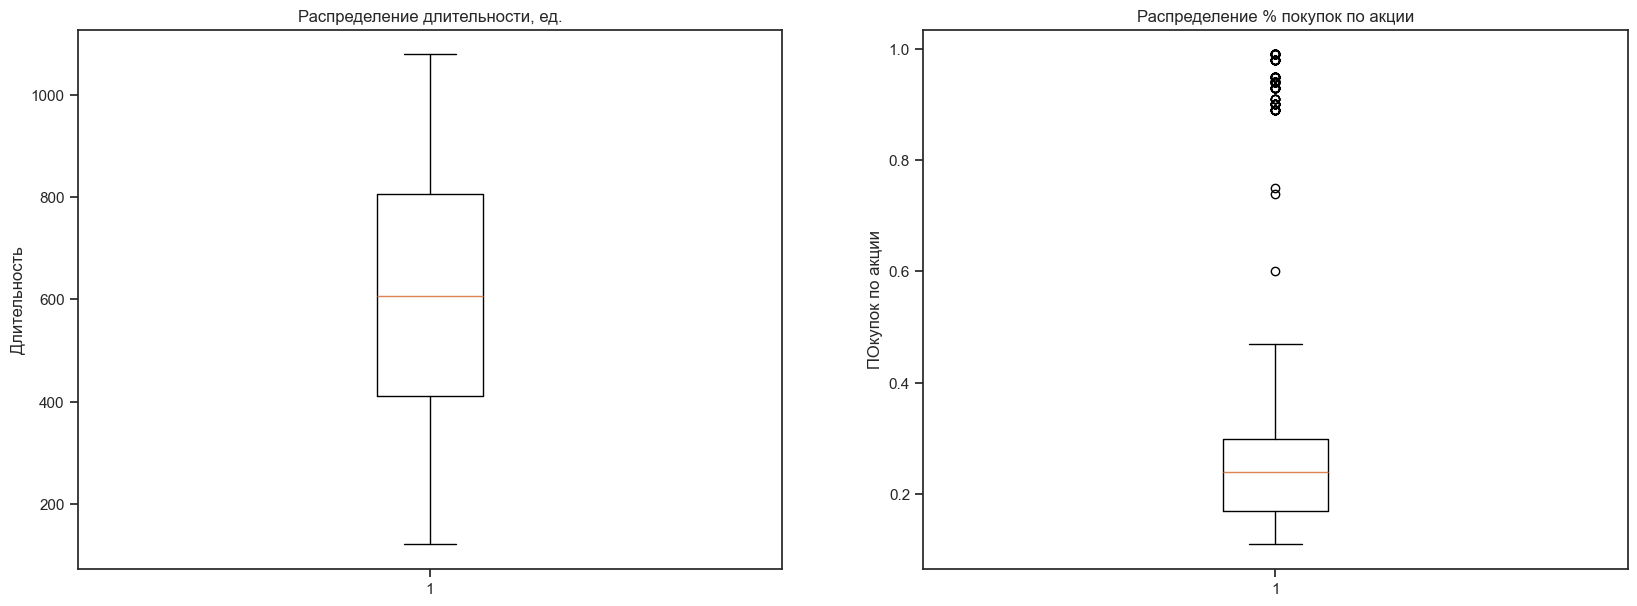

In [3324]:
# визуализируем числовые данные
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize = (20,7))

y1 = market_file_copy['Длительность']
y2 = market_file_copy['Акционные_покупки']

ax1.boxplot([y1])
ax1.set_ylabel('Длительность')
ax1.set_title('Распределение длительности, ед.')

ax2.boxplot([y2])
ax2.set_ylabel('ПОкупок по акции')
ax2.set_title('Распределение % покупок по акции')

plt.show()

Распределение признака "Средний_просмотр_категорий_за_визит"

<function matplotlib.pyplot.show(close=None, block=None)>

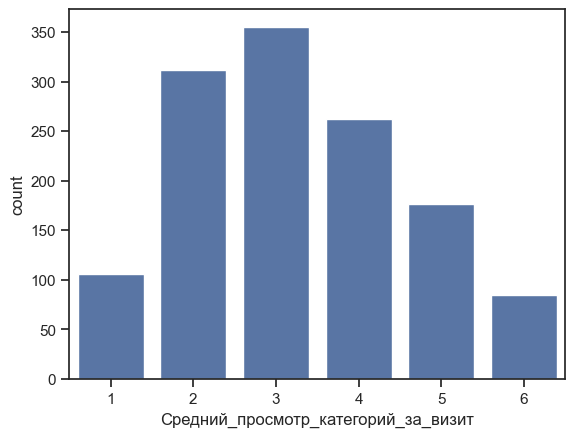

In [3325]:
sns.countplot(market_file_copy, x="Средний_просмотр_категорий_за_визит")
plt.show

Распределение признака "Неоплаченные_продукты_штук_квартал"

<function matplotlib.pyplot.show(close=None, block=None)>

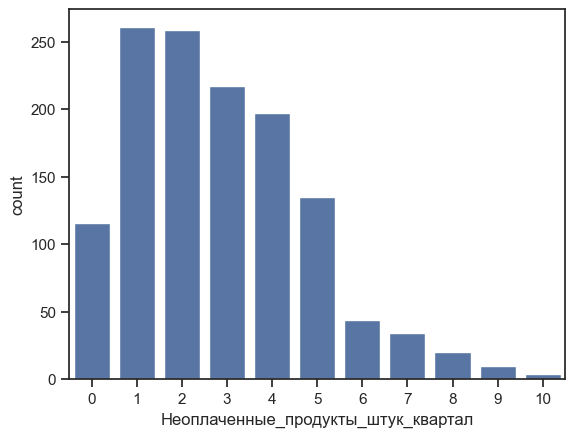

In [3326]:
sns.countplot(market_file_copy, x="Неоплаченные_продукты_штук_квартал")
plt.show

Распределение признака "Ошибка_сервиса"

<function matplotlib.pyplot.show(close=None, block=None)>

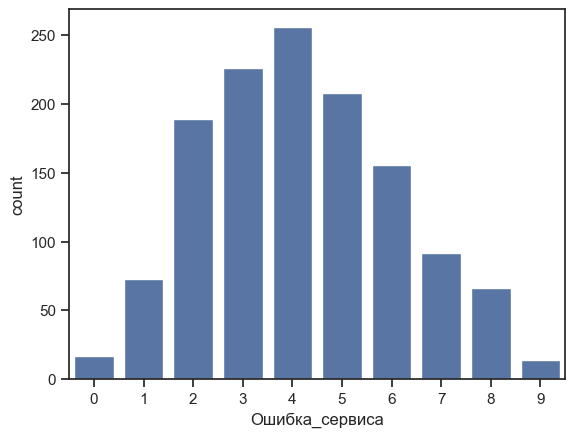

In [3327]:
sns.countplot(market_file_copy, x="Ошибка_сервиса")
plt.show

Распределение признака "Страниц_за_визит"

<function matplotlib.pyplot.show(close=None, block=None)>

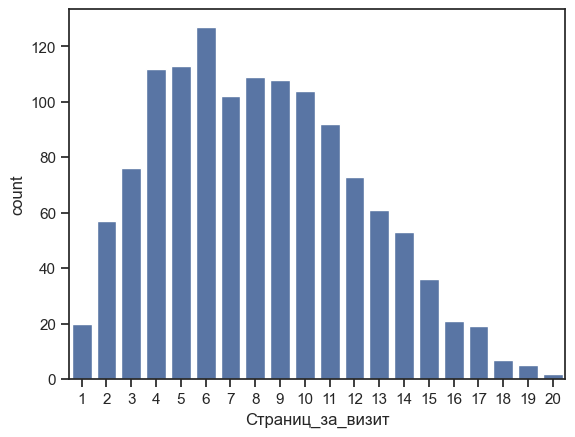

In [3328]:
sns.countplot(market_file_copy, x="Страниц_за_визит")
plt.show

Распределение признака "Маркет_актив_6_мес"

<function matplotlib.pyplot.show(close=None, block=None)>

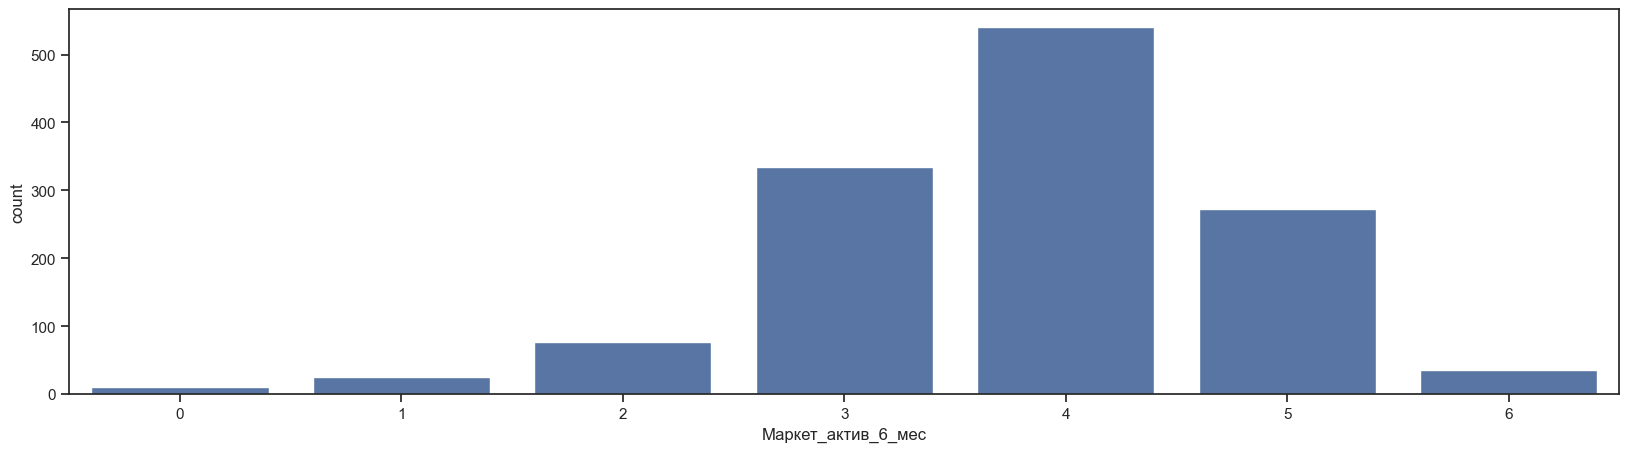

In [3329]:
plt.figure(figsize=(20, 5))
sns.countplot(market_file_copy, x="Маркет_актив_6_мес")
plt.show

Распределение признака "Маркет_актив_тек_мес"

<function matplotlib.pyplot.show(close=None, block=None)>

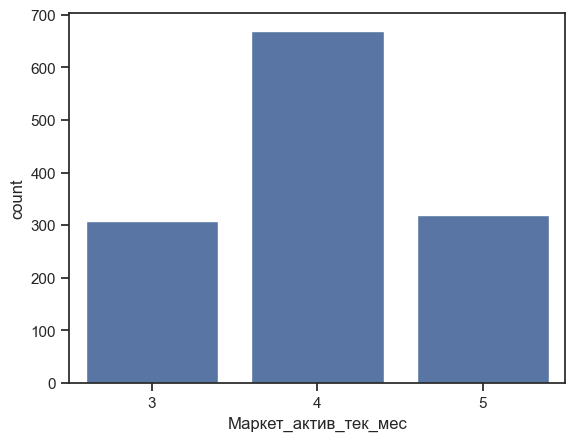

In [3330]:
sns.countplot(market_file_copy, x="Маркет_актив_тек_мес")
plt.show

#### Данные о поведении покупателей (категориальные значения)

[Text(0, 0, '959'), Text(0, 0, '338')]

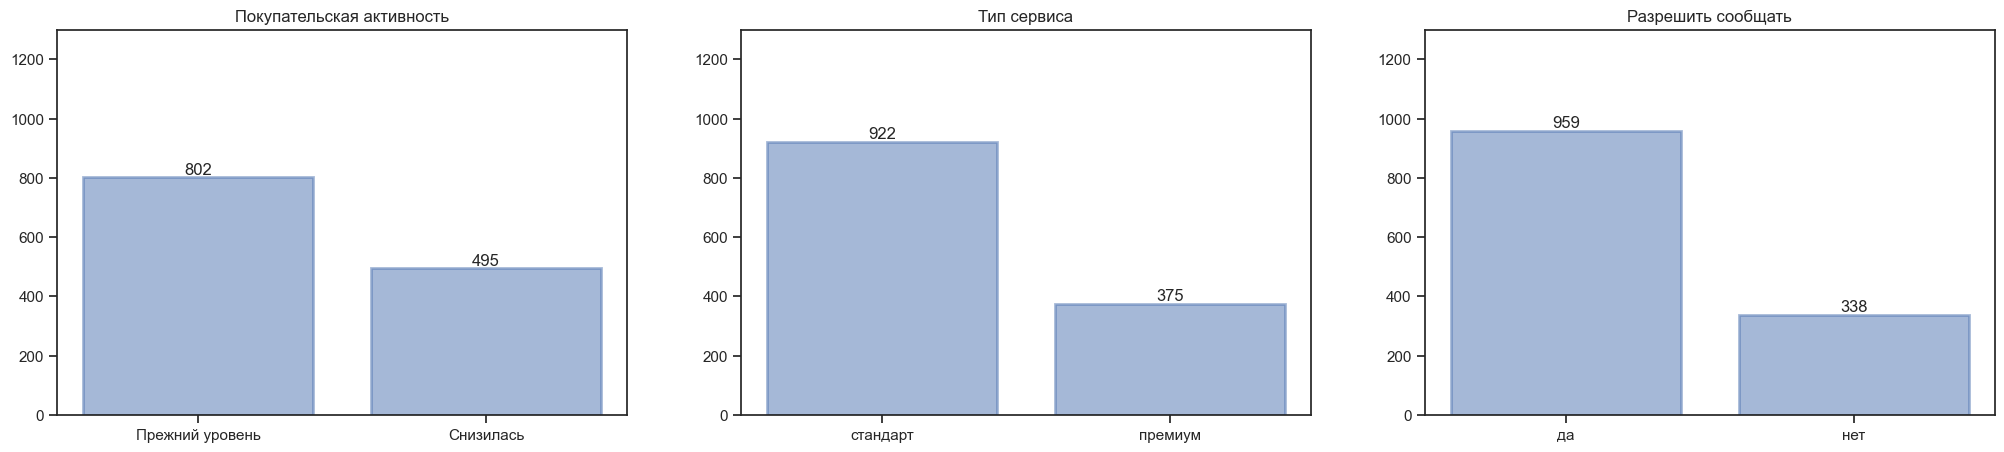

In [3331]:
y1 = market_file_copy['Покупательская активность'].value_counts().reset_index()
y2 = market_file_copy['Тип сервиса'].value_counts().reset_index()
y3 = market_file_copy['Разрешить сообщать'].value_counts().reset_index()

fig, ax = plt.subplots(1, 3, figsize=(25, 5))
bar_container = ax[0].bar(y1['Покупательская активность'], y1['count'], alpha=0.5, edgecolor="b", linewidth=2)
ax[0].set(title='Покупательская активность', ylim=(0, 1300))
ax[0].bar_label(bar_container, fmt='{:,.0f}')

bar_container1 = ax[1].bar(y2['Тип сервиса'], y2['count'], alpha=0.5, edgecolor="b", linewidth=2)
ax[1].set(title='Тип сервиса', ylim=(0, 1300))
ax[1].bar_label(bar_container1, fmt='{:,.0f}')

bar_container2 = ax[2].bar(y3['Разрешить сообщать'], y3['count'], alpha=0.5, edgecolor="b", linewidth=2)
ax[2].set(title='Разрешить сообщать', ylim=(0, 1300))
ax[2].bar_label(bar_container2, fmt='{:,.0f}')

[Text(0, 0, 'Товары для детей'),
 Text(1, 0, 'Домашний текстиль'),
 Text(2, 0, 'Косметика и аксесуары'),
 Text(3, 0, 'Техника для красоты и здоровья'),
 Text(4, 0, 'Мелкая бытовая техника и электроника'),
 Text(5, 0, 'Кухонная посуда')]

<Figure size 2500x2000 with 0 Axes>

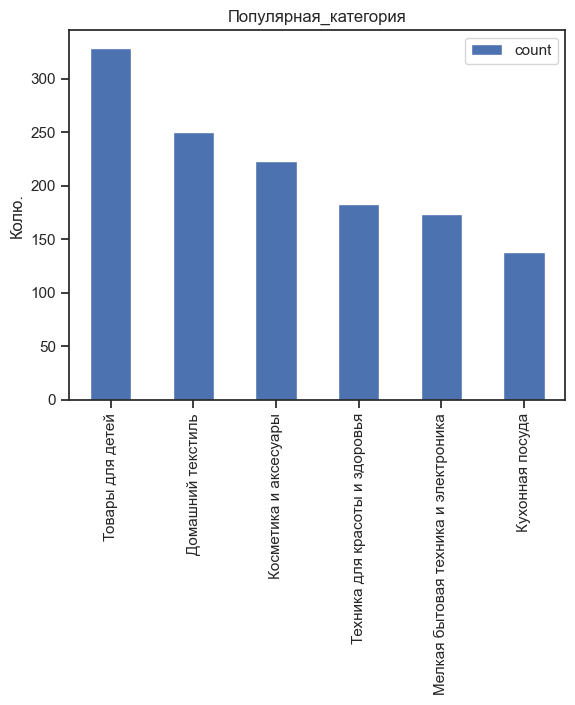

In [3332]:
y4 = market_file_copy['Популярная_категория'].value_counts().reset_index()
plt.figure(figsize=(25, 20))
fig = y4.plot(kind='bar')
fig.set_title('Популярная_категория')
fig.set_ylabel('Колю.')
fig.set_xticklabels(y4['Популярная_категория'])

#### Выводы о поведении покупателей

1. Маркетинговые активности за последние 6 мес. распределены от 1 до 7 с пиком в 4. 
2. Маркетинговые активности за последний месяц содержат значения  3, 4 и 5.
3. Всех пользователей можно разделить на тех, у кого доля покупок по акции меее 40% от всех покупок и тех, у кого эта доля превышает 85%. Можно сделаь категориальный признак.
4. Среднее количество просмотренных категорий от 1 до 6. Болшинство имеют значение от 2 до 4.
5. Количество неоплаченных товаров в корзине за 3 мес. от 0 до 10. Но самое популярное значение - всего 2.
6. Количество сбоев сайта, с которым столкнулись пользователи в среднем 4, диапазон от 0 до 6.
7. За один визит пользователь просматривает в среднем 6 страниц. В целом разброс данных от 1 до 20.
8. Сервис испытал бум активности новых пользователей в диапазоне от 400 до 800 - половина пользователей зарегистрировалась именно тогда. При этом срок использования сервиса менее 400 дней только у 25% пользователей. Динамика появления новых пользователей неуклонно снижается. Опасения руководства компании обоснованы.
9. У 61% пользователей покупателей остается прежний уровень активности. У остальных снизился. При МО нужна будет стратификация.
10. 71% пользователей имеет стандартный сервис. Остальные премиальный.
11. 74% разрешают сервису отправлять им оповещения, остальные нет.
12. Наиболее популярные группы покупаемых товаров: детские товары, домашний текстиль и косметика и аксесуары.
13. Наибольшее количество выбросов неаблюдается у показателей "акционные покупки" (можно ввести две категории), "маркетинговая активность за последний месяц" (всего три количественных значения. Вводить категориальных признак нецелесообразно, т.к. в рабочем датасете может оказаться какое то другое значение, которого в тренировочном датасете нет). В остальных количество выбросов незначительно.

#### Данные о выручке

оставим в датасете только данные по пользователям активным в последние 3 месяца.

In [3333]:
#id_three_months = market_money_copy[market_money_copy['Выручка'] == 0]['id'].drop_duplicates()
market_money_copy = market_money_copy.set_index('id') 
print(f'Размер таблицы до изменений: {market_money_copy.shape}')
market_money_copy = market_money_copy[~market_money_copy.index.isin(id_three_months)]
print(f'Размер таблицы после изменений: {market_money_copy.shape}')

Размер таблицы до изменений: (3900, 2)
Размер таблицы после изменений: (3891, 2)


переведем периоды выручки в наименования столбцов

In [3334]:
market_money_3_col = market_money_copy.pivot_table(index=market_money_copy.index, values = 'Выручка', columns = 'Период', aggfunc='sum')
market_money_3_col.columns = ['Выручка_пред_мес','Выручка_препред_мес','Выручка_тек_мес']

#### Данные о времени, проведенном на сайте

оставим в датасете только данные по пользователям активным в последние 3 месяца.

In [3335]:
market_time_copy = market_time_copy.set_index('id') 
print(f'Размер таблицы до изменений: {market_time_copy.shape}')
market_time_copy = market_time_copy[~market_time_copy.index.isin(id_three_months)]
print(f'Размер таблицы после изменений: {market_time_copy.shape}')

Размер таблицы до изменений: (2600, 2)
Размер таблицы после изменений: (2594, 2)


переведем периоды в наименованя столбцов

In [3336]:
market_time_3_col = market_time_copy.pivot_table(index=market_time_copy.index, values = 'минут', columns = 'Период', aggfunc='sum')
market_time_3_col.columns = ['Время_пред_мес', 'Время_тек_мес']

#### Данные по среднемесячной прибыли от каждого покупателя за последние 3 месяца

оставим в датасете только данные по пользователям активным в последние 3 месяца.

In [3337]:
money_copy = money_copy.set_index('id') 
print(f'Размер таблицы до изменений: {money_copy.shape}')
money_copy = money_copy[~money_copy.index.isin(id_three_months)]
print(f'Размер таблицы после изменений: {money_copy.shape}')

Размер таблицы до изменений: (1300, 1)
Размер таблицы после изменений: (1297, 1)


#### Визуализация распределения выручки, прибыли и времени на сайте

Text(0.5, 1.0, 'Прибыль за 3 мес.')

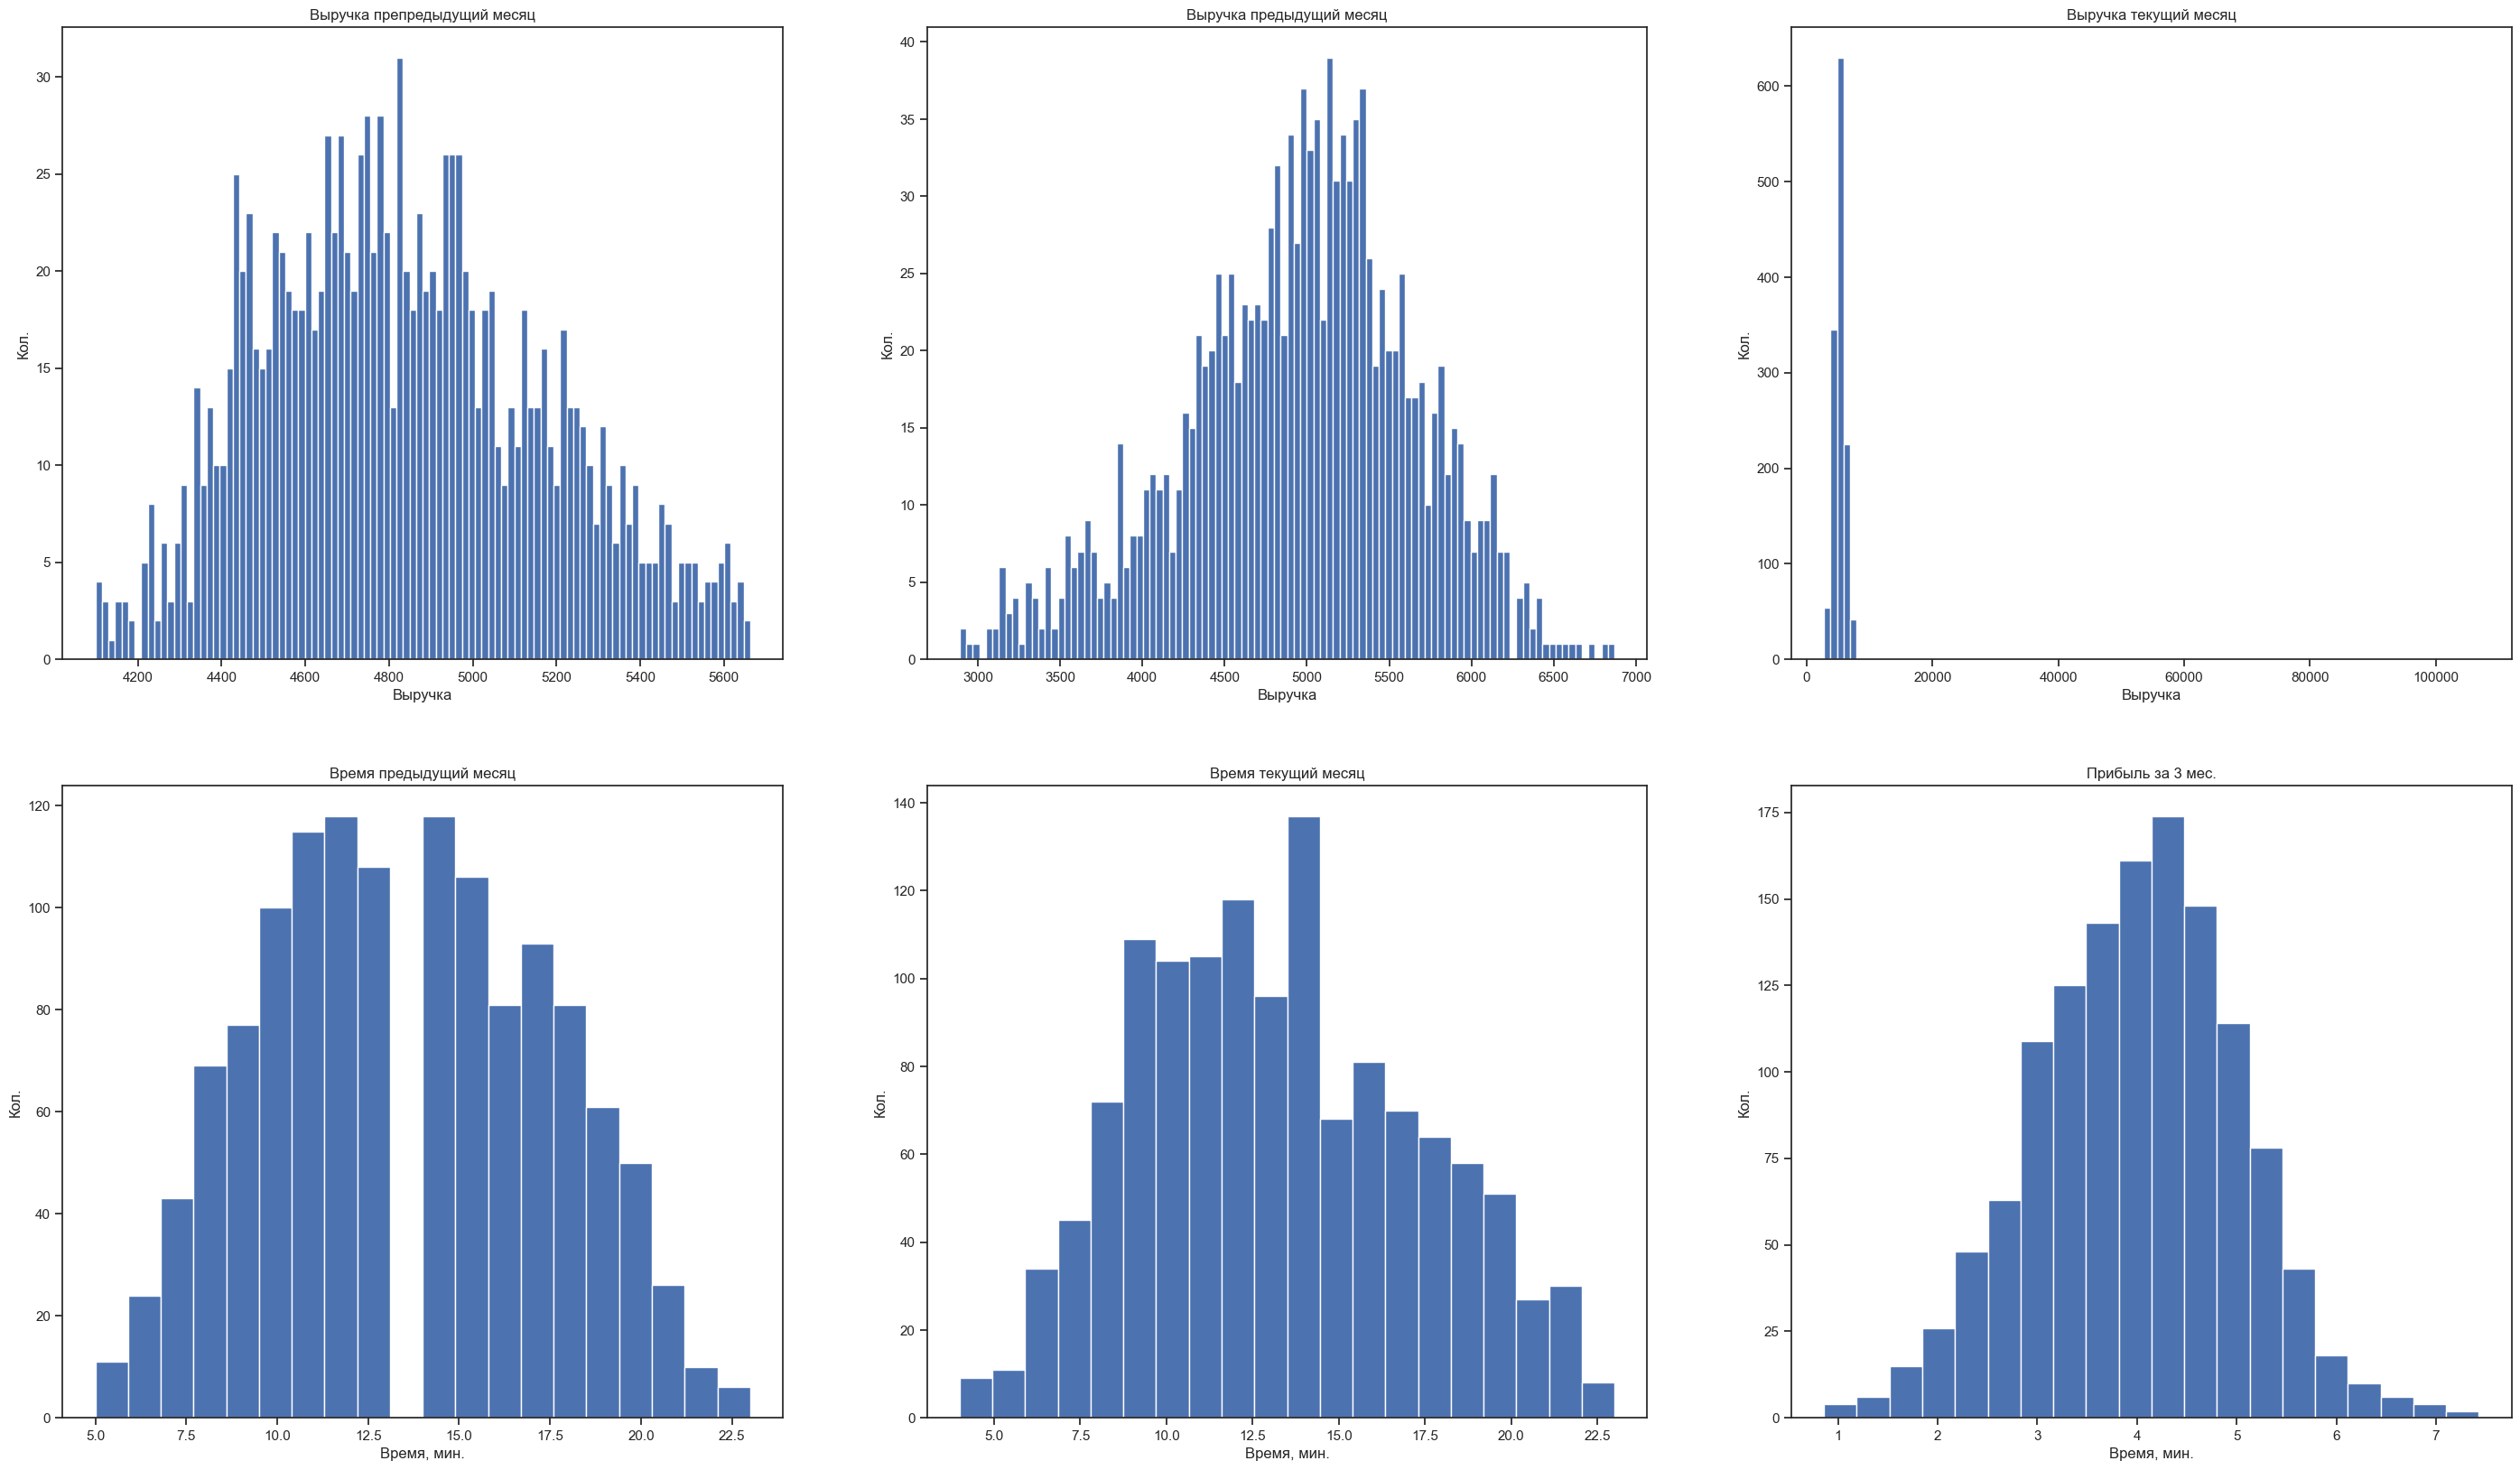

In [3338]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize = (35,20))

y1 = market_money_3_col['Выручка_препред_мес']
y2 = market_money_3_col['Выручка_пред_мес']
y3 = market_money_3_col['Выручка_тек_мес']
y4 = market_time_3_col['Время_пред_мес']
y5 = market_time_3_col['Время_тек_мес']
y6 = money_copy['Прибыль']

ax1.hist([y1], bins = 100)
ax1.set_xlabel('Выручка')
ax1.set_ylabel('Кол.')
ax1.set_title('Выручка препредыдущий месяц')

ax2.hist([y2], bins = 100)
ax2.set_xlabel('Выручка')
ax2.set_ylabel('Кол.')
ax2.set_title('Выручка предыдущий месяц')

ax3.hist([y3], bins = 100)
ax3.set_xlabel('Выручка')
ax3.set_ylabel('Кол.')
ax3.set_title('Выручка текущий месяц')

ax4.hist([y4], bins = 20)
ax4.set_xlabel('Время, мин.')
ax4.set_ylabel('Кол.')
ax4.set_title('Время предыдущий месяц')

ax5.hist([y5], bins = 20)
ax5.set_xlabel('Время, мин.')
ax5.set_ylabel('Кол.')
ax5.set_title('Время текущий месяц')

ax6.hist([y6], bins = 20)
ax6.set_xlabel('Время, мин.')
ax6.set_ylabel('Кол.')
ax6.set_title('Прибыль за 3 мес.')

In [3339]:
desc_mark = market_money_3_col.describe()
desc_minut = market_time_3_col.describe()
desc_prib = money_copy.describe()
desc_num_full = desc_mark.join(desc_minut, on = desc_mark.index, how = 'inner')
desc_num_full = desc_num_full.drop('key_0', axis = 1)
desc_num_full = desc_num_full.join(desc_prib, on = desc_num_full.index, how = 'left')
desc_num_full = desc_num_full.drop('key_0', axis = 1)
desc_num_full


,Выручка_пред_мес,Выручка_препред_мес,Выручка_тек_мес,Время_пред_мес,Время_тек_мес,Прибыль
count,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000
mean,4948.339630,4836.367772,5316.449268,13.469545,13.211257,3.997610
std,701.228571,333.438742,2942.469139,3.936323,4.220222,1.010813
min,2890.000000,4098.000000,2758.700000,5.000000,4.000000,0.860000
25%,4498.500000,4585.000000,4706.600000,11.000000,10.000000,3.300000
50%,5005.500000,4812.000000,5180.300000,13.000000,13.000000,4.040000
75%,5409.000000,5055.000000,5761.300000,17.000000,16.000000,4.670000
max,6869.500000,5663.000000,106862.200000,23.000000,23.000000,7.430000


#### Выводы по итогам исследовательского анализа данных

1. На протяжении 3 мес. средняя выручка растет, но также растет разброс между значениям. Показатель СКО вырос почти в 3 раза с 333 до 834. Максимальная выручка выросла с 5663 до 7800. При этом минимальное значение уменьшилось с 4098 до 2758. Т.о. за 3 месяца существенно возросла дифференциация между пользователями. Вероятно меньшая часть покупателей стала постоянными покупателями и нарастила траты, остальные же сократили свои покупки на сайте магазина.
2. За два месяца динамика проведенного на сайте времени существенно не изменилась.

### Объединение таблиц

In [3340]:
df_full = market_file_copy.join(market_money_3_col, on = market_file_copy.index, how = 'inner')
df_full = df_full.drop('key_0', axis = 1)
df_full = df_full.join(market_time_3_col, on = market_file_copy.index, how = 'inner')
df_full = df_full.drop('key_0', axis = 1)
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1297 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская активность            1297 non-null   object 
 1   Тип сервиса                          1297 non-null   object 
 2   Разрешить сообщать                   1297 non-null   object 
 3   Маркет_актив_6_мес                   1297 non-null   int64  
 4   Маркет_актив_тек_мес                 1297 non-null   int64  
 5   Длительность                         1297 non-null   int64  
 6   Акционные_покупки                    1297 non-null   float64
 7   Популярная_категория                 1297 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1297 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 10  Ошибка_сервиса                       1297 non-null   int64  
 11  Страниц_за_визит            

Добавим столбец отражающий изменение выручки по каждому клиенту

In [3341]:
df_full['Выручка_изм_за_3мес'] = df_full['Выручка_тек_мес'] - df_full['Выручка_препред_мес']

### Корреляционный анализ

#### Матрица корреляций

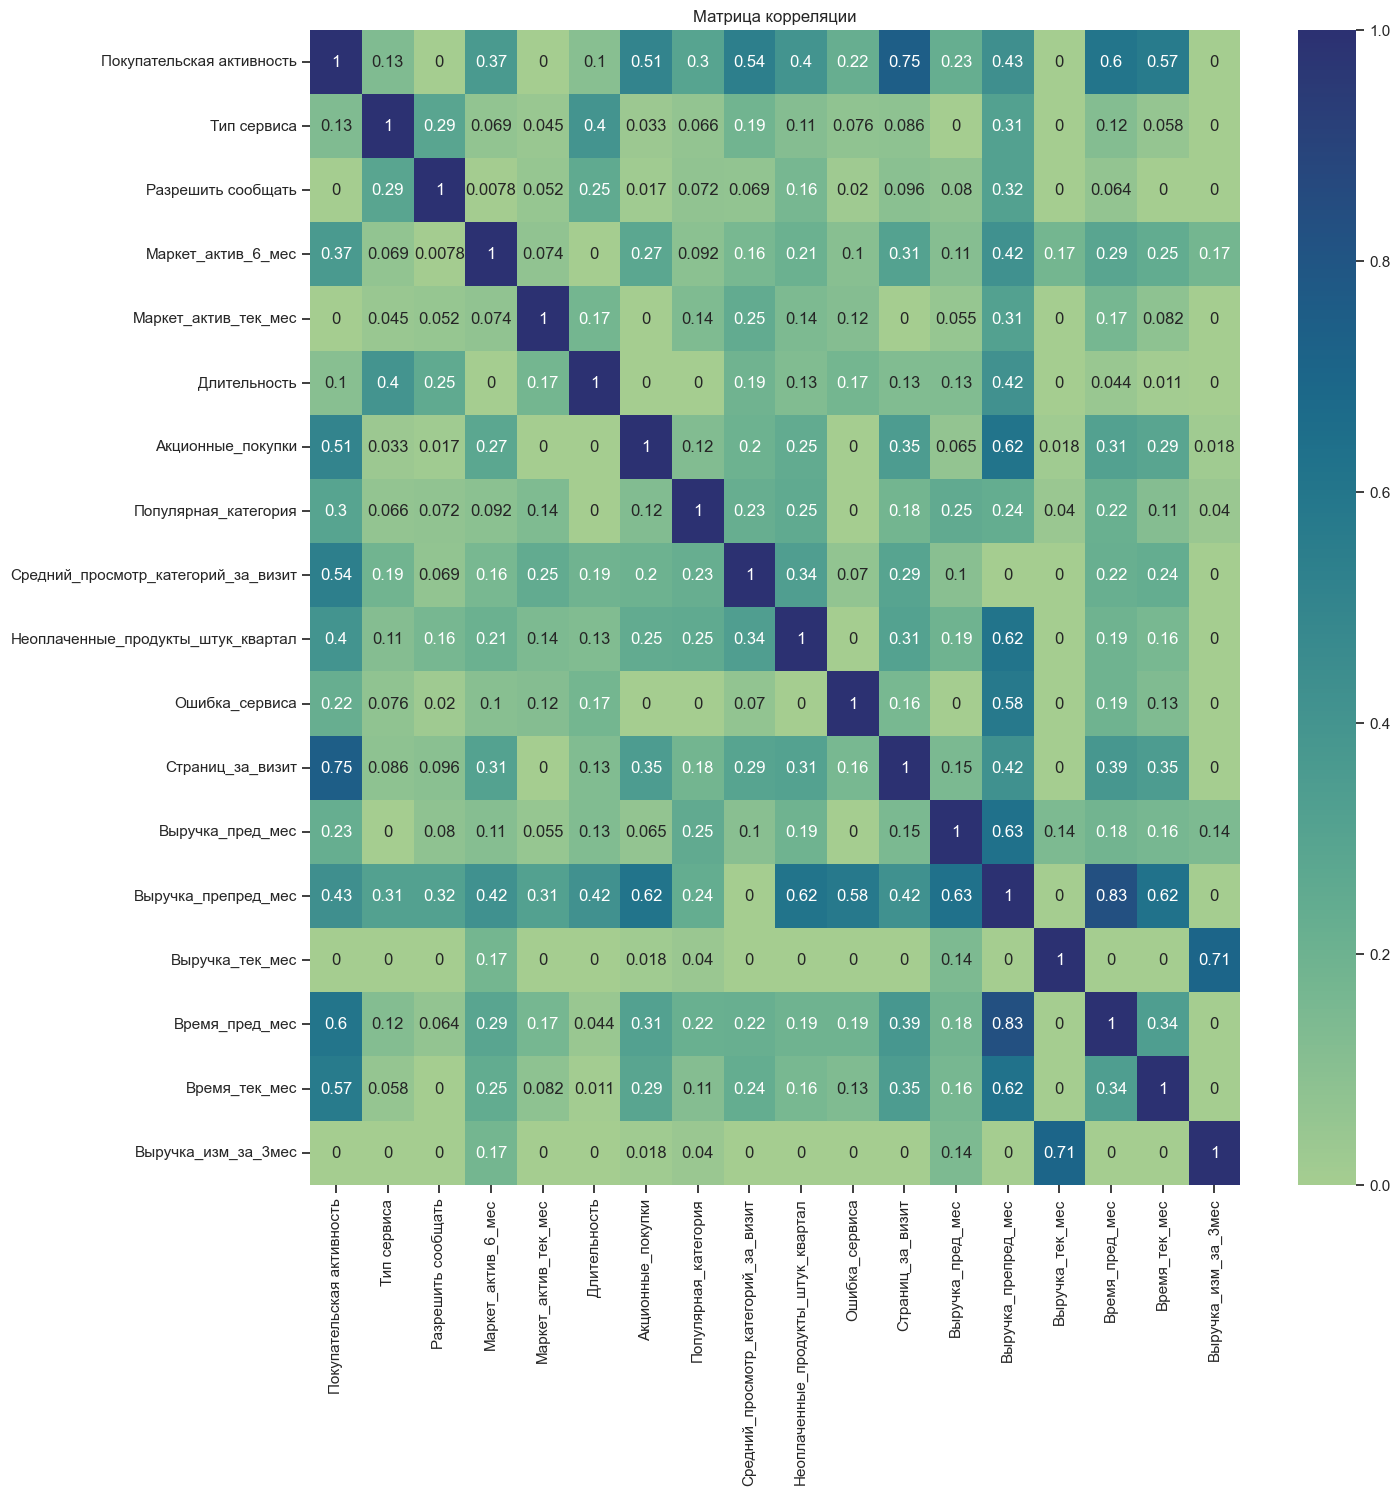

In [3342]:
plt.figure(figsize=(15, 15))
sns.heatmap(df_full.phik_matrix(interval_cols = ['Маркет_актив_6_мес','Выручка_изм_за_3мес','Выручка_пред_мес', 'Выручка_тек_мес', 'Длительность', 'Акционные_покупки'
                                                 ]), annot=True, cmap='crest')

plt.title('Матрица корреляции')
plt.show()

Среди признаков, предоставленных заказчиком, нет признаком с ккорр > 0.9. Мультиколлинеарность отсутствует.

#### Зависимость динамики выручки от количественных признаков

##### Зависимость покупательской активности от количественных показателей

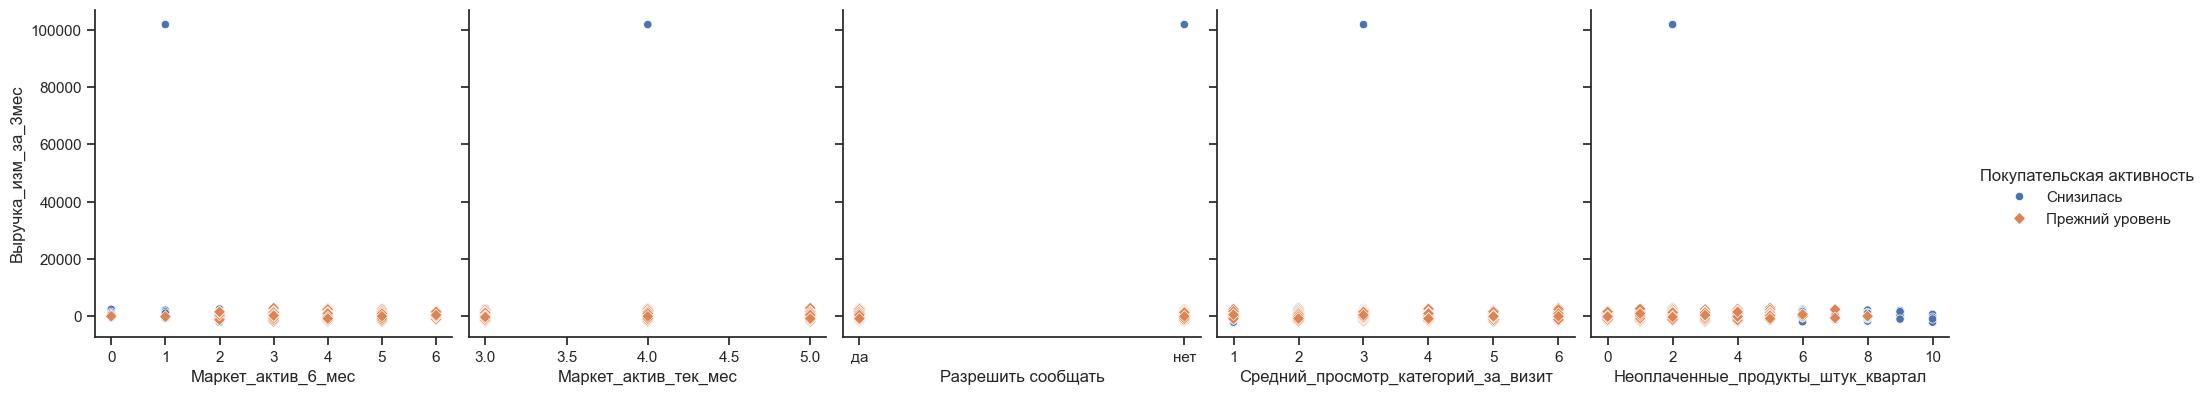

In [3343]:
sns.set_theme(style="ticks")
sns.pairplot(df_full, hue="Покупательская активность", y_vars = ['Выручка_изм_за_3мес'], x_vars=['Маркет_актив_6_мес', 
                                                                                                 'Маркет_актив_тек_мес', 
                                                                                                 'Разрешить сообщать', 
                                                                                                 'Средний_просмотр_категорий_за_визит', 
                                                                                                 'Неоплаченные_продукты_штук_квартал'], markers = ['o', 'D'], height = 4)

Маркетинговая активность за полгода демонстрирует эффективность. Чем более высокая активность, тем меньше вероятность снижения активности пользователя. \
Активность за текущий месяц не демонстрирует связи с потребительской активностью. \
Средний просмотр и количество неоплаченных продуктов демонстируют устойчивю связь с потребительской активностью.

##### Зависимость покупательской активности от популярных категорий

Между покупательской активностью и популярными категория ккорр всего 0,3. Необходимо рассмотреть является ли эта закономерность равномерной. Сравним динамику изменения выручки от пользователей за 3 месяца по популярным категориям.

In [3344]:
cons_activ_per_category_count = df_full.pivot_table(index = 'Покупательская активность', values = 'Выручка_изм_за_3мес', columns = 'Популярная_категория', aggfunc='count')
cons_activ_per_category_count

Популярная_категория,Домашний текстиль,Косметика и аксесуары,Кухонная посуда,Мелкая бытовая техника и электроника,Техника для красоты и здоровья,Товары для детей
Покупательская активность,,,,,,
Прежний уровень,149,118,72,147,132,184
Снизилась,101,105,66,27,51,145


<Axes: xlabel='Выручка_изм_за_3мес', ylabel='Популярная_категория'>

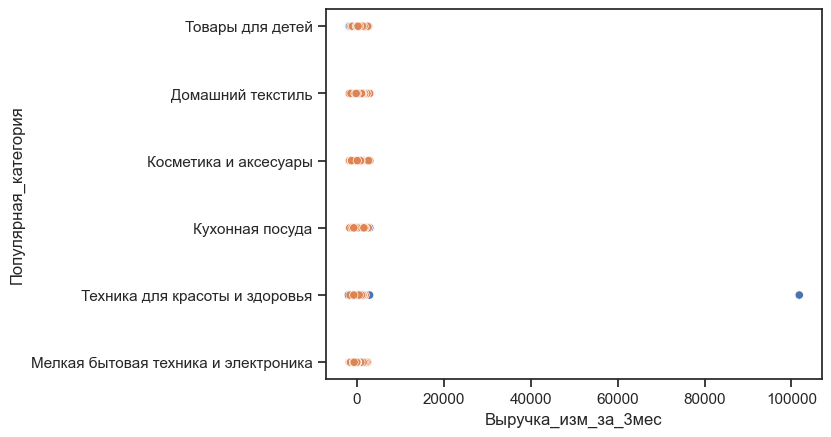

In [3345]:
sns.scatterplot(df_full, y = df_full['Популярная_категория'], x = df_full['Выручка_изм_за_3мес'], hue = df_full['Покупательская активность'], legend = False)

Больше всего снижение выручки наблюдается у покупателей, чьими любимыми категориями являются товары для детей, кухонная посуда, косметика и акссесуары. По этим категориям пользовательская активность за 3 месяца снизилась почти у половины покупателей.

##### Зависимость покупательской активности от типа сервиса

In [3346]:
cons_activ_per_service_type = df_full.pivot_table(index = 'Покупательская активность', values = 'Выручка_изм_за_3мес', columns = 'Тип сервиса', aggfunc='count')
cons_activ_per_service_type

Тип сервиса,премиум,стандарт
Покупательская активность,,
Прежний уровень,206,596
Снизилась,169,326


Покупательская активность чаще снижалась у пользователей с премим подпиской 

Выводы:
1. Для модели отберем признаки с высоким ккорр с целевым признаком: маркетинговая активность за 6 месяцев, акционные покупки, популярная категория, средний просмотр категорий за визит, неоплаченные продукты за квартал, страниц за визит, выручка за последние 1-2-3 месяца, время на сайте за предыдущий и текущий месяц.

### Использование пайплайна

Создадим датафрэйм для выбора лучшей модели. Оставим в нем только необходимые для обучения признаки. \
Переведем целевой показатель в булев тип.

In [3347]:
df_full_for_model = df_full[['Тип сервиса','Популярная_категория', 'Маркет_актив_6_мес', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит','Неоплаченные_продукты_штук_квартал','Страниц_за_визит','Выручка_пред_мес','Выручка_препред_мес','Выручка_тек_мес','Время_пред_мес','Время_тек_мес','Покупательская активность']].copy()

В качестве метрики выберем roc_auc, т.к. данная метрика нечувствительна к дисбалансу классов. 

In [3348]:
X_train, X_test, y_train, y_test = train_test_split(
    df_full_for_model.drop('Покупательская активность', axis = 1),
    df_full_for_model['Покупательская активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_full['Покупательская активность'])

X_train.shape, X_test.shape

# создаём списки с названиями признаков
ohe_columns = ['Популярная_категория']
ord_columns = ['Тип сервиса']
num_columns = ['Маркет_актив_6_мес', 
               'Акционные_покупки', 
               'Средний_просмотр_категорий_за_визит',
               'Неоплаченные_продукты_штук_квартал',
               'Страниц_за_визит',
               'Выручка_пред_мес',
               'Выручка_препред_мес',
               'Выручка_тек_мес',
               'Время_пред_мес',
               'Время_тек_мес']

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )
# заполнение пропусков и Ordinal-кодирование для подготовки признаков из списка ord_columns
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['премиум', 'стандарт']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
y_test_pred = randomized_search.predict(X_test)
y_test_proba = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_proba[:,1])}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
           

In [3349]:
result = pd.DataFrame(randomized_search.cv_results_)
print(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score'))

   rank_test_score                                       param_models  \
7                1  LogisticRegression(penalty='l1', random_state=...   
4                2                             KNeighborsClassifier()   
5                3                             KNeighborsClassifier()   
1                4            DecisionTreeClassifier(random_state=77)   
0                5            DecisionTreeClassifier(random_state=77)   
2                6            DecisionTreeClassifier(random_state=77)   
3                7            DecisionTreeClassifier(random_state=77)   
8                8            DecisionTreeClassifier(random_state=77)   
9                9            DecisionTreeClassifier(random_state=77)   
6               10                             KNeighborsClassifier()   

   mean_test_score                                             params  
7         0.900065  {'preprocessor__num': StandardScaler(), 'model...  
4         0.897475  {'preprocessor__num': StandardSc

Вывод:
наиболее высокий показатель показала логистическая регрессия. Результат ожидаемый, так как основная часть датасета это количественные показатели. Целевой показатель потребительской активности, который рассчитывается заказчиком, имеет линейную взаимосвязь с показателями выручки и времени, проведенном на сайте.

### Анализ важности признаков

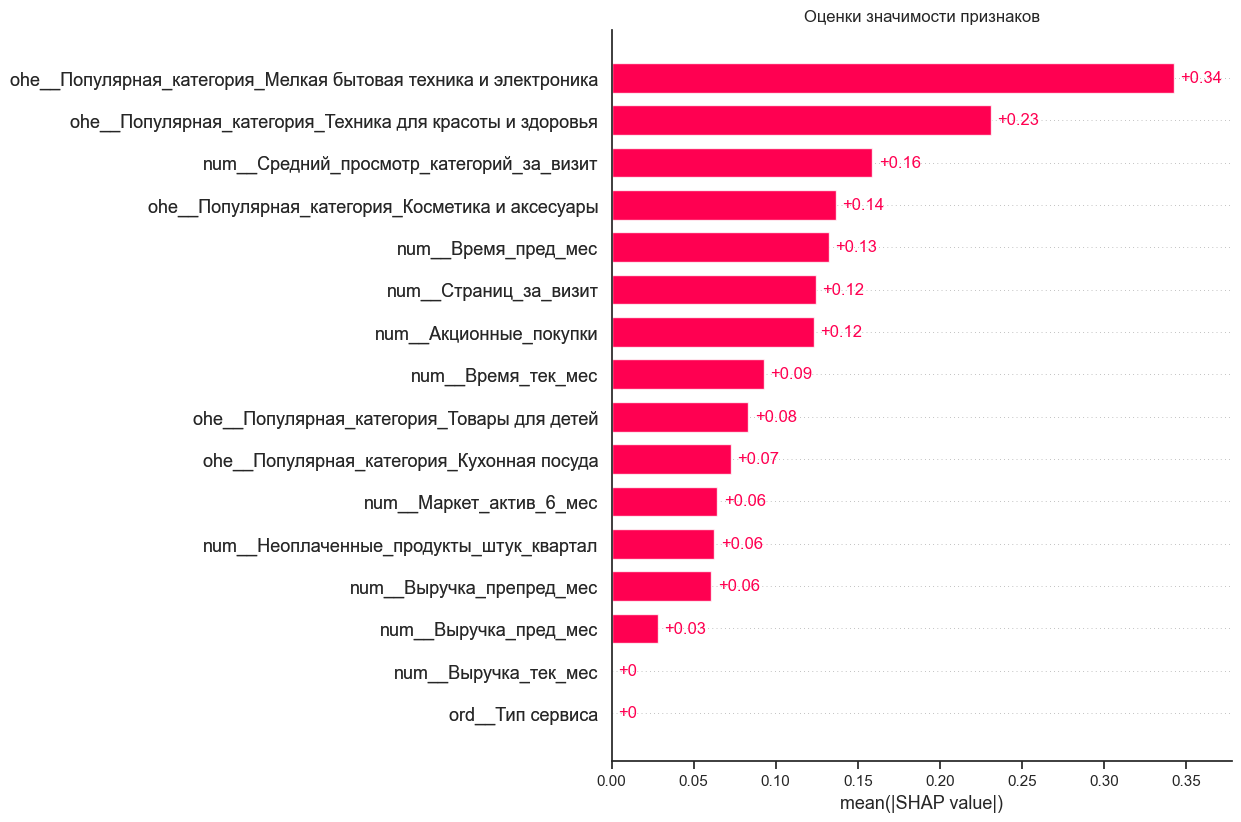

None

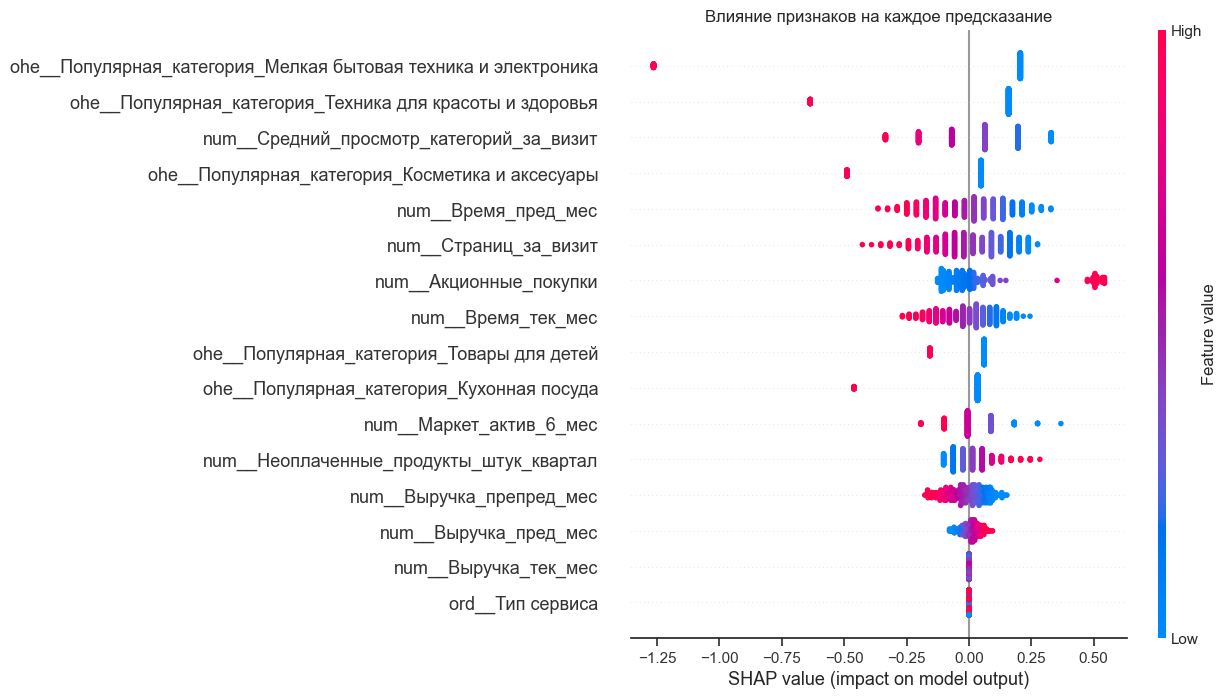

In [3350]:
X_train_2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
explainer = shap.LinearExplainer(randomized_search.best_estimator_.named_steps['models'], X_train_2)

X_test_2 = pipe_final.named_steps['preprocessor'].transform(X_test)

feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()

X_test_2 = pd.DataFrame(X_test_2, columns=feature_names)
 
shap_values = explainer(X_test_2)

plt.title('Оценки значимости признаков')

display(shap.plots.bar(shap_values, max_display=17))

plt.title('Влияние признаков на каждое предсказание')
shap.plots.beeswarm(shap_values, max_display=16)
plt.show()

Выводы по значимости признаков:
1. Наиболее стабильными покупателями являются покупатели мбт и электроники и техники для красоты и здоровья.
2. Наиболее значимыми признаками оказались те, которые отражают затраты времени пользователя на нахождение на сайте: время за предыдущий месяц, количество просмотренных страниц и среднее количество просмотренных категорий. Все связи в данном случае прямые. Чем больше времени пользователь роводит на сайте - тем больше вероятность того, что его активность не снизится.
3. Важную роль играет склонность к покупкам акционных товаров. Но связь обратная: стремящиеся к покупкам преимущественно по акциям чаще других снижают потребительскую активность.
4. Наименее важными признаками являются тип сервиса, и склонность к покупкам косметики, кухонной посуды и товаров для детей.

### Сегментация покупателей

Спрогнозируем вероятность снижения активности потребителей для тестовой и тренировочной выбрки.

In [3351]:
y_test_proba = randomized_search.predict_proba(X_test)[:,1]
y_train_proba = randomized_search.predict_proba(X_train)[:,1]

Создадим общий датасет со столбцом вероятности снижения потребительской активности

In [3352]:
X_test_full = X_test.copy()
X_train_full = X_train.copy()
X_test_full['Покупательская_активность_вер'] = y_test_proba
X_train_full['Покупательская_активность_вер'] = y_train_proba
df_full_for_model = pd.concat([X_train_full, X_test_full])

Добавим данные о прибыли с каждого покупателя

In [3353]:
df_full_for_model = df_full_for_model.join(money_copy, on = df_full_for_model.index, how = 'inner')
df_full_for_model = df_full_for_model.drop('key_0', axis = 1)

#### Анализ показателя прибыли по пользователям

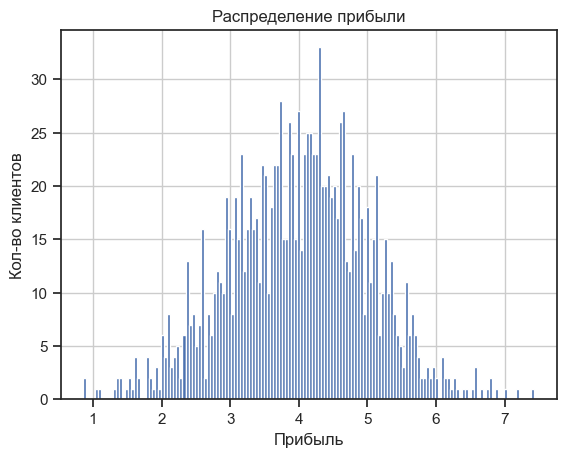

In [3354]:
plt.hist(df_full_for_model['Прибыль'], bins=150)

plt.xlabel('Прибыль')
plt.ylabel('Кол-во клиентов')
plt.title('Распределение прибыли')
plt.grid()
plt.show()

In [3355]:
print(df_full_for_model['Прибыль'].describe())

count    1297.000000
mean        3.997610
std         1.010813
min         0.860000
25%         3.300000
50%         4.040000
75%         4.670000
max         7.430000
Name: Прибыль, dtype: float64


##### Выделение сегмента для исследования

Посмотрим есть ли среди наиболее прибыльных клиентов (верхний квартиль) склонные к снижению активности. Если да, то следует особое внимание обратить именно на них в выработке стратегии сохранения рыночного положения заказчика.

In [3356]:
df_threat_for_money = df_full_for_model.query('Прибыль > 4.67 and Покупательская_активность_вер > 0.75')
df_threat_for_money

,Тип сервиса,Популярная_категория,Маркет_актив_6_мес,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Страниц_за_визит,Выручка_пред_мес,Выручка_препред_мес,Выручка_тек_мес,Время_пред_мес,Время_тек_мес,Покупательская_активность_вер,Прибыль
id,,,,,,,,,,,,,,
215503,стандарт,Домашний текстиль,2,0.24,1,5,1,5046.0,4119.0,4886.1,7,8,0.997257,5.23
215510,стандарт,Техника для красоты и здоровья,3,0.22,2,7,2,4244.0,4814.0,4242.7,9,14,0.905139,5.01
215832,стандарт,Товары для детей,4,0.99,4,4,4,5065.5,4662.0,5545.2,14,10,0.919559,5.30
215505,стандарт,Товары для детей,4,0.31,2,3,3,3951.0,4698.0,3982.2,7,7,0.944297,6.55
215485,стандарт,Косметика и аксесуары,3,0.99,1,2,7,4201.0,4234.0,5065.5,10,14,0.974197,5.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215714,стандарт,Кухонная посуда,3,0.40,3,7,6,5854.0,4864.0,7063.0,13,9,0.890777,4.85
215738,премиум,Мелкая бытовая техника и электроника,4,0.23,1,3,2,4773.0,4500.0,4445.4,9,7,0.889430,5.25
216357,стандарт,Кухонная посуда,4,0.99,3,4,7,5700.5,4745.0,6658.6,16,15,0.775111,5.02


In [3357]:
print(f'Сумма прибыли от всех покупателей: {df_full_for_model['Прибыль'].sum()}')
print(f'Сумма прибыли от наиболее прибыльных покупателей с высокой вероятностью снижения активности: {df_threat_for_money['Прибыль'].sum()}')

Сумма прибыли от всех покупателей: 5184.9
Сумма прибыли от наиболее прибыльных покупателей с высокой вероятностью снижения активности: 446.09


В ближайшее время заказчик может рассчитывать на снижение совокупной прибыли на 441 ед или на 8,5% из-за потери части наиболее прибыльных покупателей.

##### Исследование сегмента по количественным признакам

Text(0.5, 1.0, 'Страниц_за_визит, ед.')

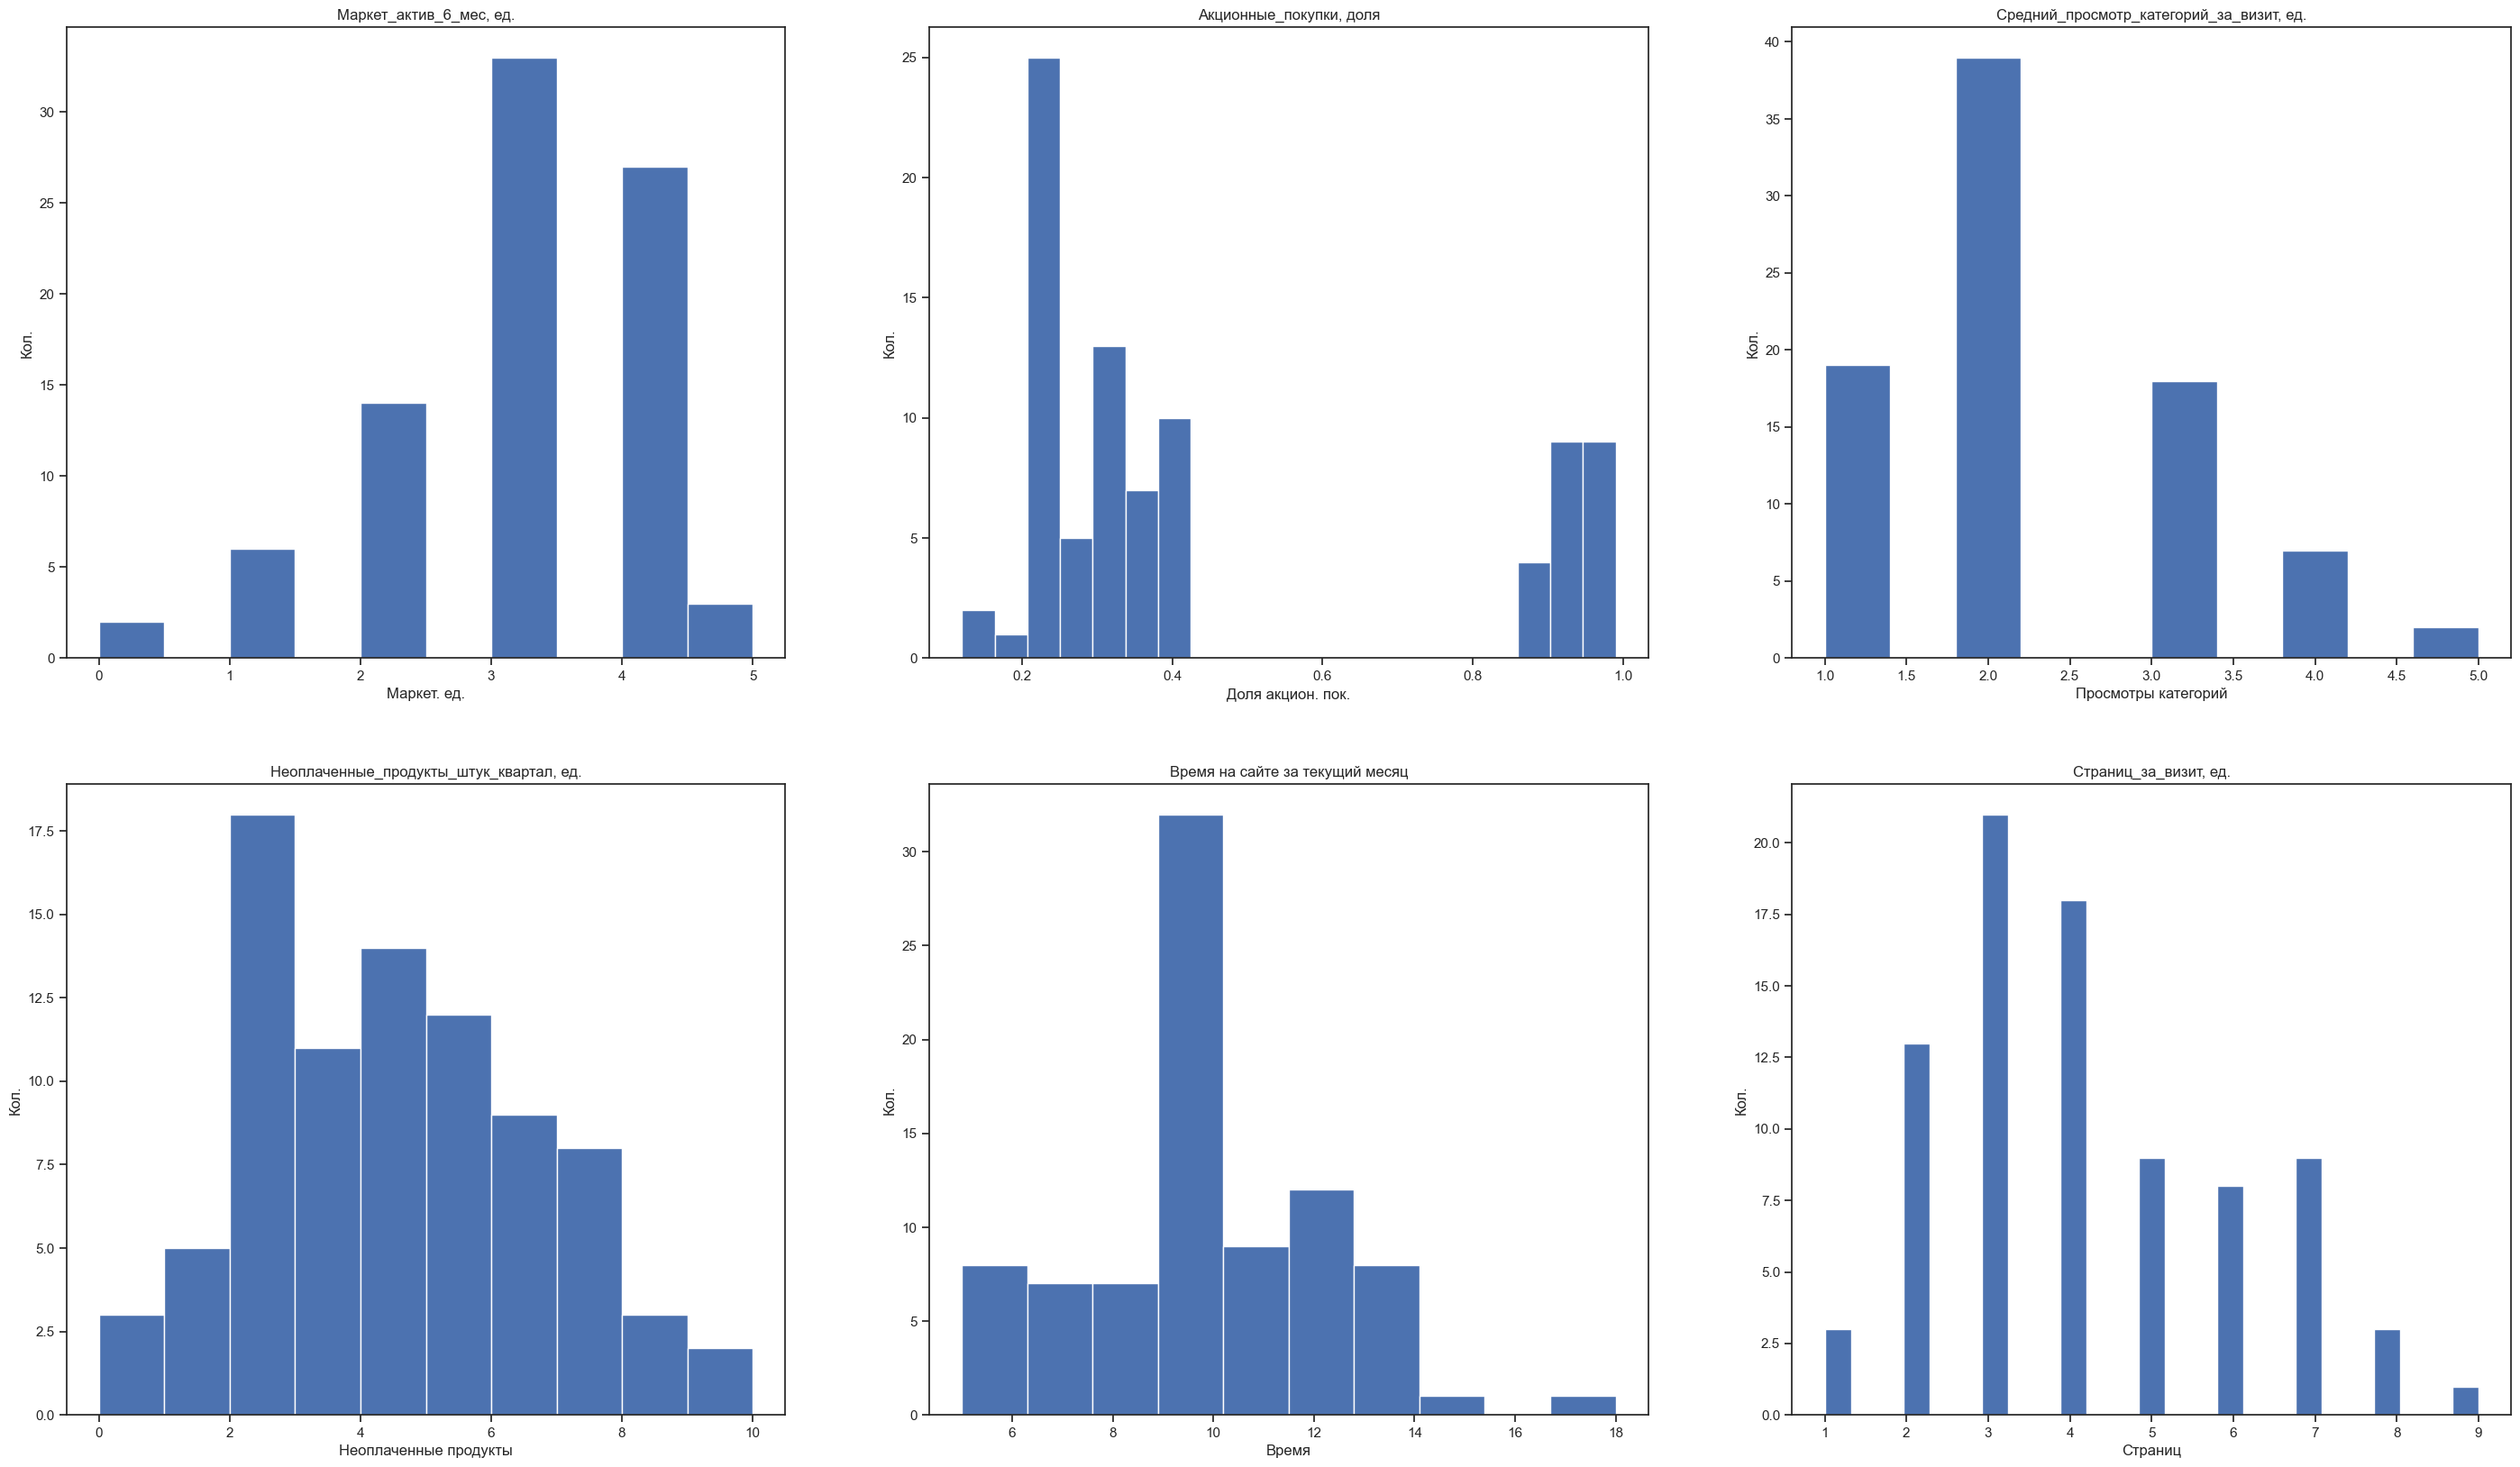

In [3358]:
# визуализируем числовые данные
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2,3, figsize = (35,20))

y1 = df_threat_for_money['Маркет_актив_6_мес']
y2 = df_threat_for_money['Акционные_покупки']
y3 = df_threat_for_money['Средний_просмотр_категорий_за_визит']
y4 = df_threat_for_money['Неоплаченные_продукты_штук_квартал']
y5 = df_threat_for_money['Время_тек_мес']
y6 = df_threat_for_money['Страниц_за_визит']

ax1.hist([y1], bins = 10)
ax1.set_xlabel('Маркет. ед.')
ax1.set_ylabel('Кол.')
ax1.set_title('Маркет_актив_6_мес, ед.')

ax2.hist([y2], bins = 20)
ax2.set_xlabel('Доля акцион. пок.')
ax2.set_ylabel('Кол.')
ax2.set_title('Акционные_покупки, доля')

ax3.hist([y3], bins = 10)
ax3.set_xlabel('Просмотры категорий')
ax3.set_ylabel('Кол.')
ax3.set_title('Средний_просмотр_категорий_за_визит, ед.')

ax4.hist([y4], bins = 10)
ax4.set_xlabel('Неоплаченные продукты')
ax4.set_ylabel('Кол.')
ax4.set_title('Неоплаченные_продукты_штук_квартал, ед.')

ax5.hist([y5], bins = 10)
ax5.set_xlabel('Время')
ax5.set_ylabel('Кол.')
ax5.set_title('Время на сайте за текущий месяц')

ax6.hist([y6], bins = 25)
ax6.set_xlabel('Страниц')
ax6.set_ylabel('Кол.')
ax6.set_title('Страниц_за_визит, ед.')

Вывод по анализу количественных показателей:
1. Прибыльные клиенты, склонные к снижению активности, более зациклены на узком перечне категорий товаров. В основном они смотрят 2, максимум 3 категории товаров. У генеральной совокупности гораздо больший процент просмотра 4 и более категорий.
2. Рассматриаемый сегмент меньше охвачен маркетинговой активностью заказчика. Мода и в рассмариаемой и в ген совокупности равна 4 активностям, но в генеральной совокупности гораздо большую долю составляет 5 и более активностей. В рассматриваемой выборке такая активность скорее редкое исключение.
3. Количество просмотренных страниц также существенно ниже, чем показал анализ ген совокупности.
4. Склонности покупать все по акции чаще, чем у генеральной совокупности, не выявлено
4. В целом: модель выявила, что наибольшее позхитивное влияние на сохранение потребительской активности имеет время, проведенное на сайте (включая просмотренные категории и страницы). Прибыльные клиенты имеют слишком низкий показатель по этим признакам вероятно вызванный недостаточным охватом маркетинга заказчика.

##### Исследование по категориальным признакам

###### Популярная категория

Рассмотрим соответствует ли распределение популярных категорий у генеральной совокупности и у рассматриваемого сегмента

In [3359]:
df_threat_for_money_category = df_threat_for_money.pivot_table(index = 'Популярная_категория', values = 'Прибыль', aggfunc=['count', 'sum'])
df_threat_for_money_category = df_threat_for_money_category.reset_index()
df_threat_for_money_category.columns = ['Популярная_категория', 'Кол. сегмент', 'Прибыль сегмент']
df_threat_for_money_category = df_threat_for_money_category.set_index('Популярная_категория')
df_threat_for_money_category = df_threat_for_money_category.join(df_full['Популярная_категория'].value_counts(), on = df_threat_for_money_category.index, how = 'inner')
df_threat_for_money_category = df_threat_for_money_category.drop('key_0', axis = 1)
df_threat_for_money_category['Процент_потери'] = df_threat_for_money_category['Кол. сегмент'] / df_threat_for_money_category['count']
df_threat_for_money_category = df_threat_for_money_category.sort_values(by = 'Процент_потери', ascending = False)
df_threat_for_money_category

,Кол. сегмент,Прибыль сегмент,count,Процент_потери
Популярная_категория,,,,
Косметика и аксесуары,23,124.41,223,0.103139
Товары для детей,24,128.33,329,0.072948
Кухонная посуда,9,46.47,138,0.065217
Домашний текстиль,16,80.06,250,0.064000
Техника для красоты и здоровья,8,42.21,183,0.043716
Мелкая бытовая техника и электроника,5,24.61,174,0.028736


<Axes: xlabel='Прибыль', ylabel='Покупательская_активность_вер'>

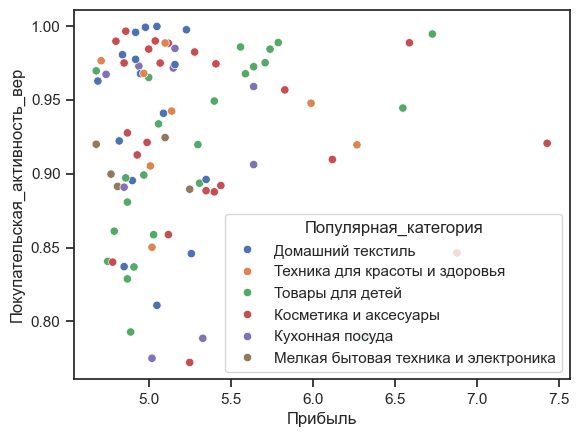

In [3360]:
sns.scatterplot(df_threat_for_money, y = df_threat_for_money['Покупательская_активность_вер'], x = df_threat_for_money['Прибыль'], hue = df_threat_for_money['Популярная_категория'])

Выводы по результатам анализа категориальных показателей:
1. Основную часть анализируемого сегмента составляют покупатели косметики и товаров для детей. Также существенную долю составляют покупатели текстиля.
2. Несмотря на то, что сегмент составляет 6,5% от ген совокупности, он включает в себя 10,3% пользователей, любимой категорией которых является косметика и аксессуары. Также здесь более высокий процент любителей товарой для детей и домашнего текстиля чем в среднем.

##### Тип сервиса

In [3361]:
df_threat_for_money_service_type = df_threat_for_money.pivot_table(index = 'Тип сервиса', values = 'Прибыль', aggfunc=['count', 'sum'])
df_threat_for_money_service_type

,count,sum
,Прибыль,Прибыль
Тип сервиса,,
премиум,30,161.67
стандарт,55,284.42


Влияния типа сервиса на прибыльность и возможность снижения активности не выявлено. Использовать этот инструмент не рекомендуется.
Сравним распределение по количественным показателям по сравнению с генеральной совокупностью

##### Выводы для выбранного сегмента

1. Для удержания клиентов выбранного сегмента можно порекомендовать активизировать адресную маркетинговую активность, направленную на рекламу товаров в других сегментах, отличающихся от самого популярного.
2. Пересмотреть набор привелегий по типу сервиса "премиум". Анализ показал отстствие влияния этого показателя на потребительскую активность.
3. Проанализировать внешний вид и механику самого сервиса, чтобы расшириь/облегчить работу пользователей и стимулировать их смотреть больше страниц.

### Общий вывод

Наш клиент - интернет-магазин потребительских товаров, опасающийся снижения потребительской активности. \
На основе анализа-данных и моделирования заказчик хочет разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность. \

Нам были предоставлены данные о потребительско активности, выручке, прибыли и времени проведенном на сайте пользователями за последние 3 месяца. \
Была проведена работа по удалению выбросов, приведению данных к нужному типу. Дубликаты не обнаружены. \
Также из анализа были убраны данные по пользователям неактивным последние 3 месяца. \ 

Для выделения сегмента пользователей, наиболее склонных к снижению активности, была использована модель логистической регрессии, показавшая наилучший результат при прогнозировании. Для этого был собран пайплайн из четырех моделей, двух кодировщиков и двух скейлеров. На лучшей модели был осуществлен прогноз вероятности снижения потребительской активности покупателей. Был сделан вывод о том, что сильнее всего на стремление покупателей сохранить свою активность влияют признаки, отражающие время, проведенное на сайте. \

В итоге был выделен сегмент наиболее прибыльных пользователей при этом имеющих высокую вероятность снизить свою активность. \
Анализ показал, что данные пользователи имеют тенденцию зацикливаться на ограниченном перечне категорий (в частности, косметики и товаров для детей), просматривают меньшее количество страниц чем в среднем и на них воздействует меньшее чем в среднем количество маркетинговыз активностей. \

Были разработаны рекомендации заказчику по работе с данным сегментом, включащие в себя:
1. Активизация маркетинговой активности данному сегменту;
2. Пересмотр типов сервиса, потому что тип сервиса "Премиум" не демонстрирует вляния на стремление пользователей продолжаь пользоваться интернет-магазином.
3. Анализ дружелюбности интерфейса сайта к пользователям. Пересмотр в пользу симулирования пользователей к просмтру большего кольичества страниц.